Import all the Dependencies 

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 
import warnings
import numpy as np
import os

warnings.filterwarnings('ignore')

Set all the Constants 

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25

Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed = 123, 
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [24]:
class_Names = dataset.class_names
class_Names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [25]:
len(dataset)

68

In [26]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

Visualize some of the images from the dataset

2024-08-19 00:24:59.492127: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


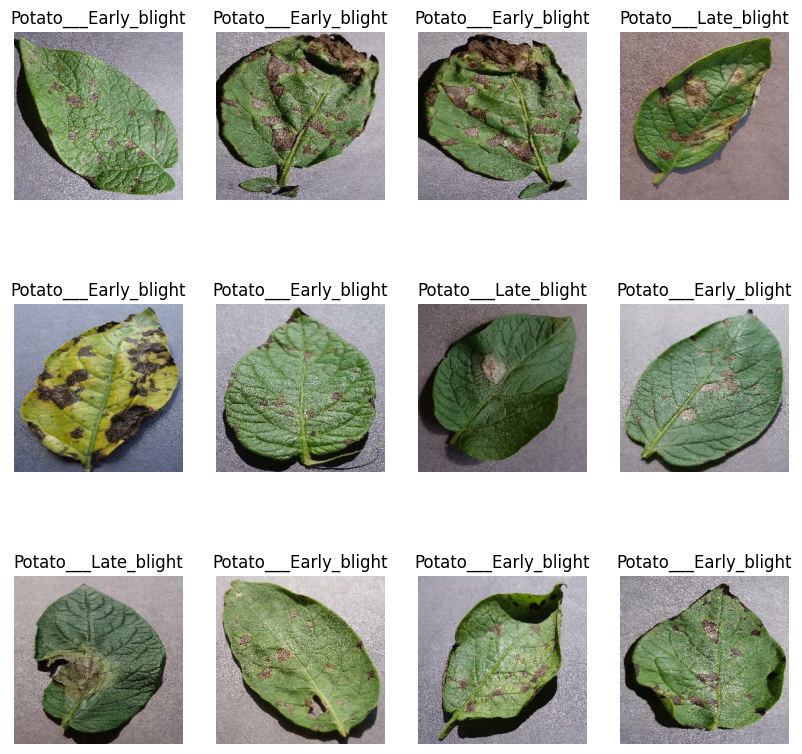

In [27]:
plt.figure(figsize=(10,10))
for image_Batch, label_Batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_Batch[i].numpy().astype("uint8"))
        plt.title(class_Names[label_Batch[i]])
        plt.axis("off")

In [28]:
def get_Dataset_Partition_tf(ds, train_Split = 0.8, val_Split = 0.1, test_Split = 0.1, shuffle = True, shuffle_Size = 10000):
    assert(train_Split + test_Split + val_Split) == 1 #Changes 

    ds_Size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_Size, seed = 12)

    train_Size = int(train_Split * ds_Size)
    val_Size = int(val_Split * ds_Size)

    train_Ds = ds.take(train_Size)
    val_Ds = ds.skip(train_Size).take(val_Size)
    test_Ds = ds.skip(train_Size).skip(val_Size)

    return train_Ds, val_Ds, test_Ds

In [29]:
train_Ds, val_Ds, test_Ds = get_Dataset_Partition_tf(dataset)

In [30]:
len(train_Ds)

54

In [31]:
len(val_Ds)

6

In [32]:
len(test_Ds)

8

In [33]:
train_Ds = train_Ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_Ds = val_Ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_Ds = test_Ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [34]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)  #Changes 
])

In [35]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [36]:
#Changes
train_ds = train_Ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [37]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    #data_augmentation,   #Changes 
    layers.Conv2D(32,kernel_size = (3, 3), activation='relu', input_shape = input_shape), 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = input_shape)

In [38]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(
    optimizer = 'adamax',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [40]:
history = model.fit(
    train_Ds, 
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_Ds
)

Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 654ms/step - accuracy: 0.4853 - loss: 0.9314 - val_accuracy: 0.6302 - val_loss: 0.8865
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 653ms/step - accuracy: 0.6100 - loss: 0.8590 - val_accuracy: 0.7292 - val_loss: 0.6656
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 708ms/step - accuracy: 0.7461 - loss: 0.5985 - val_accuracy: 0.8281 - val_loss: 0.4444
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 809ms/step - accuracy: 0.8467 - loss: 0.4011 - val_accuracy: 0.9062 - val_loss: 0.2788
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 805ms/step - accuracy: 0.8897 - loss: 0.2637 - val_accuracy: 0.8958 - val_loss: 0.2184
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 916ms/step - accuracy: 0.9202 - loss: 0.2010 - val_accuracy: 0.9167 - val_loss: 0.1630
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9308 - loss: 0.1747 - val_accuracy: 0.9375 - val_loss: 0.1807
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 790ms/step - accuracy: 0.9458 - loss: 0.1345 - val_accurac

In [41]:
scores = model.evaluate(test_Ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.9955 - loss: 0.0363


In [42]:
print(scores)

[0.07301441580057144, 0.984375]


In [43]:
history

In [44]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 54}

In [45]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

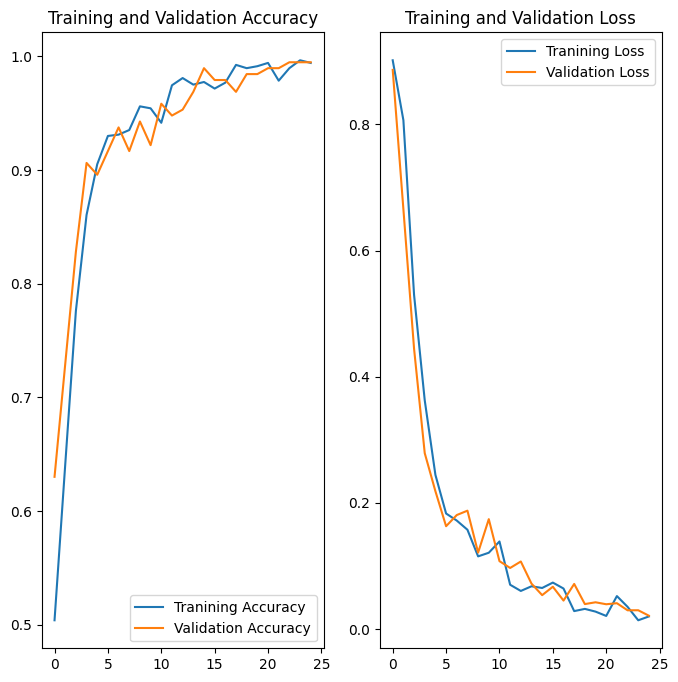

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = "Tranining Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Tranining Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First image to predict
Actual Label: Potato___healthy
(32, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Predicted Label: Potato___healthy


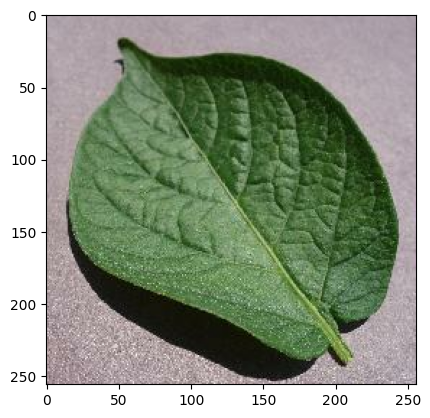

In [75]:
index = 16
for image_Batch, label_Batch in test_Ds.take(1):
    first_image = image_Batch[index].numpy().astype('uint8')
    first_label = label_Batch[index].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_Names[first_label])
    print(image_Batch.shape)
    batch_prediction = model.predict(image_Batch)
    print("Predicted Label:",class_Names[np.argmax(batch_prediction[index])])


In [56]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    print(predictions)
    predicted_class = class_Names[np.argmax(batch_prediction[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[9.9999857e-01 1.2755397e-06 6.9382537e-08]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[[3.963964e-10 8.112538e-05 9.999188e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[1.14771304e-07 4.21888046e-02 9.57811058e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[9.9999976e-01 2.1941553e-07 7.6392153e-14]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[1.0000000e+00 2.3555383e-08 1.6914668e-16]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[9.9783915e-01 2.1608770e-03 6.1976893e-15]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[1.000000e+00 3.455368e-08 6.820266e-16]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[9.9998832e-01 1.1631277e-05 1.6048427e-08]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[9.9999511e-01 4.8897427e-06 1.7407409e-11]]


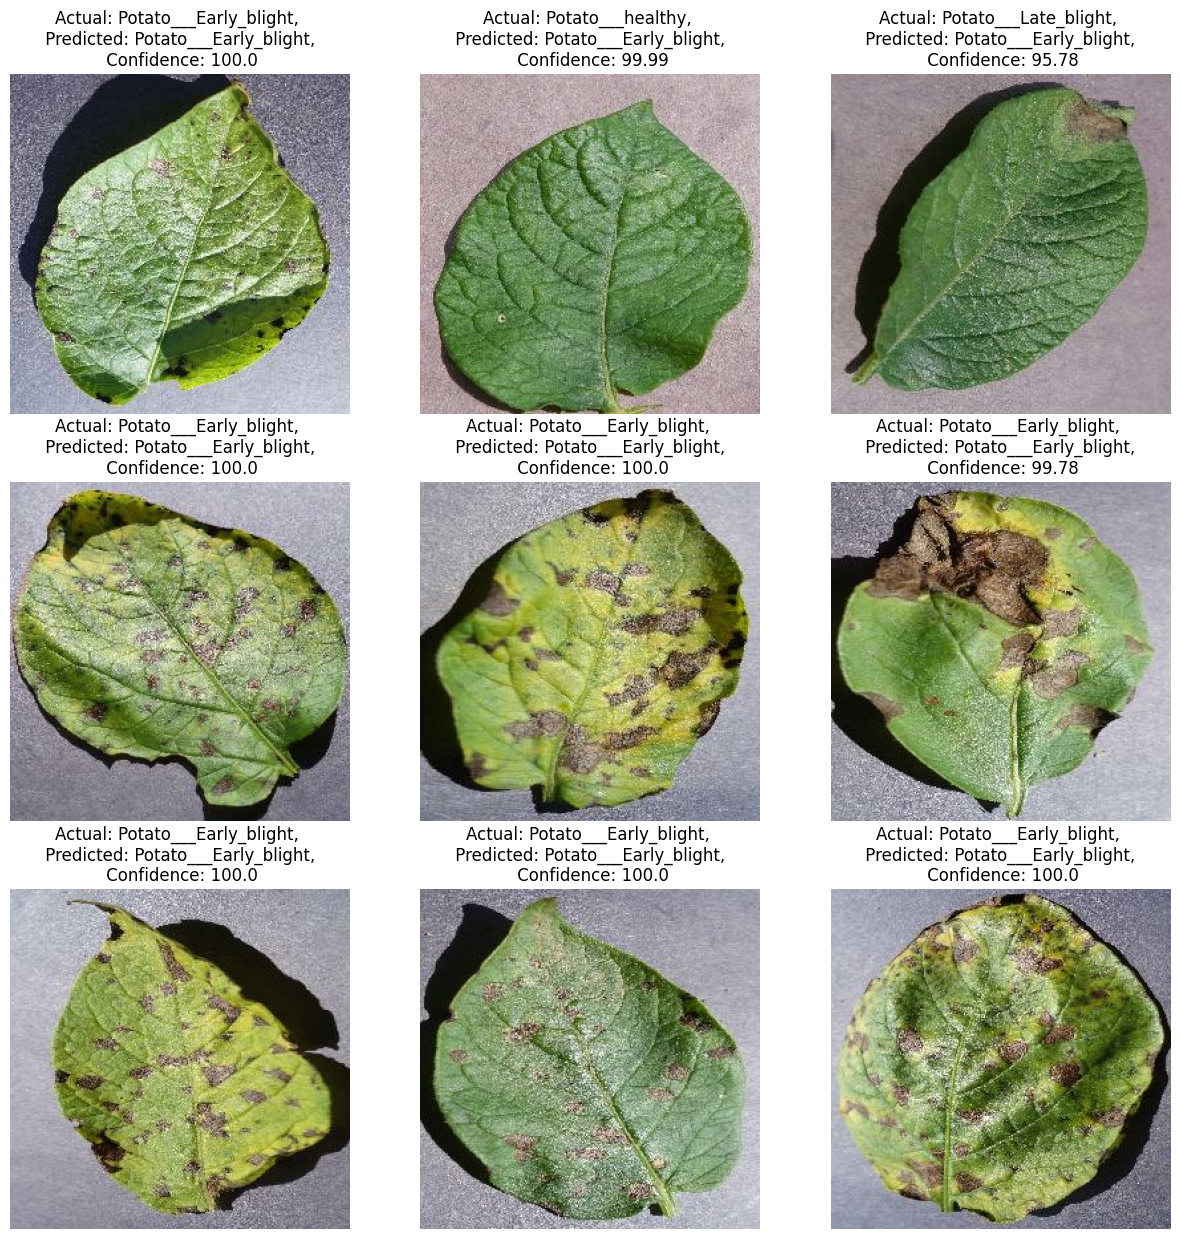

In [63]:
plt.figure(figsize=(15, 15))
for images, labels in test_Ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_Names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}")
        plt.axis("off")

In [51]:
save_dir = "../models"
os.makedirs(save_dir, exist_ok=True)

model_version = 2
model.save(os.path.join(save_dir, f"{model_version}.keras"))